In [23]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
#import données
dfa=pd.read_csv("D:/4_Python_ML/Chap1/dpe-v2-logements-existants.csv")
dfn=pd.read_csv("D:/4_Python_ML/Chap1/dpe-v2-logements-neufs.csv")

df=dfa.select_dtypes(exclude=['object', 'category'])

C:\Users\marvi\AppData\Local\Temp\ipykernel_19820\1965376990.py:2: DtypeWarning: Columns (12,48,190,191,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  dfa=pd.read_csv("D:/4_Python_ML/Chap1/dpe-v2-logements-existants.csv")


In [13]:
#liste complete des variables
noms_variables = dfa.columns
liste_noms_variables = noms_variables.tolist()
liste_noms_variables.sort()
print(liste_noms_variables)

['Adresse_(BAN)', 'Adresse_brute', 'Année_construction', 'Appartement_non_visité_(0/1)', 'Apports_internes_saison_chauffe_', 'Apports_internes_saison_froid', 'Apports_solaires_saison_chauffe', 'Apports_solaires_saison_froid', 'Besoin_ECS', 'Besoin_ECS_bâtiment', 'Besoin_ECS_logement', 'Besoin_chauffage', 'Besoin_refroidissement', 'Besoin_refroidissement_dépensier', 'COP_générateur_ECS_n°1', 'COP_générateur_ECS_n°2', "Cage_d'escalier", 'Catégorie_ENR', 'Classe_altitude', 'Classe_inertie_bâtiment', 'Code_INSEE_(BAN)', 'Code_postal_(BAN)', 'Code_postal_(brut)', "Complément_d'adresse_bâtiment", "Complément_d'adresse_logement", 'Configuration_installation_ECS', 'Configuration_installation_chauffage_n°1', 'Configuration_installation_chauffage_n°2', 'Conso_5_usages/m²_é_finale', 'Conso_5_usages_par_m²_é_primaire', 'Conso_5_usages_é_finale', 'Conso_5_usages_é_finale_énergie_n°1', 'Conso_5_usages_é_finale_énergie_n°2', 'Conso_5_usages_é_finale_énergie_n°3', 'Conso_5_usages_é_primaire', 'Conso_E

In [14]:
#export dans un fichier txt
mon_fichier = 'liste_variables_dfa.txt'
with open(mon_fichier, 'w', encoding='utf-8') as fichier :
    for nom in liste_noms_variables :
        fichier.write(nom + '\n')

print(f"La liste complète des variables a été stockée dans le fichier : {mon_fichier}")

La liste complète des variables a été stockée dans le fichier : liste_variables_dfa.txt


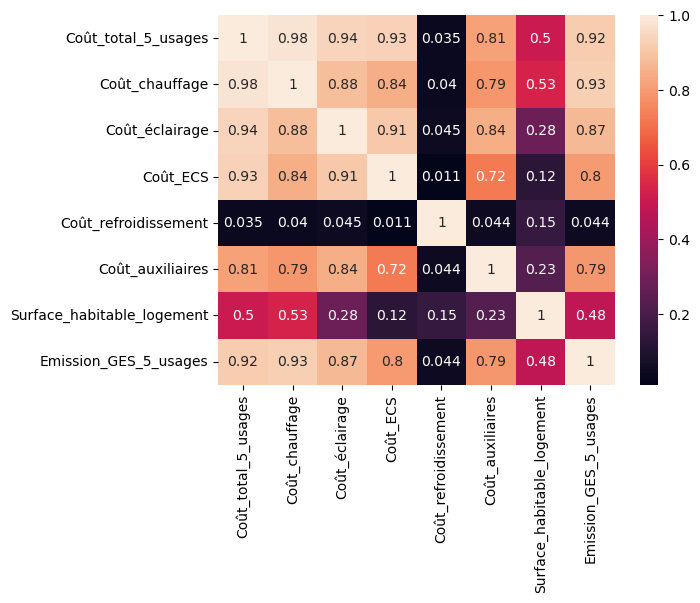

In [7]:
#matrice corrélation avec 8 variables
mat_corr = df[['Coût_total_5_usages','Coût_chauffage','Coût_éclairage','Coût_ECS','Coût_refroidissement', 'Coût_auxiliaires', 'Surface_habitable_logement' , 'Emission_GES_5_usages']].corr('pearson')
sb.heatmap(mat_corr, annot=True)
plt.show()

Sélection de variables : "coût_refroidssement" n'est pas corrélée avec "coût_chauffage", il peut être judicieux de ne pas la garder. "coût_éclairage" semble être très  corrélée avec la plupart des variables restantes, pour éviter la multicolinéarité, il peut être bon de ne pas la considérer.
On effectue alors la régression avec les 6 variables restantes .

REGRESSION MULTIPLE

In [46]:
def imputer_par_moyenne(df: pd.DataFrame) -> pd.DataFrame:
    """
    Parcourt un DataFrame et remplace toutes les valeurs manquantes (NaN) 
    des colonnes numériques par la moyenne de leur colonne respective.
    
    Args:
        df (pd.DataFrame): Le DataFrame d'entrée.
        
    Returns:
        pd.DataFrame: Le DataFrame avec les valeurs manquantes imputées.
    """
    
    # Créer une copie du DataFrame pour éviter de modifier l'original (bonne pratique)
    df_impute = df.copy()
    
    # 1. Identifier les colonnes numériques
    # On itère uniquement sur les colonnes dont le type est numérique (int, float)
    colonnes_numeriques = df_impute.select_dtypes(include=np.number).columns
    
    print(f"Colonnes numériques à imputer : {list(colonnes_numeriques)}")

    # 2. Parcourir les colonnes numériques
    for colonne in colonnes_numeriques:
        # Calculer la moyenne de la colonne
        moyenne_colonne = df_impute[colonne].mean()
        
        # Remplacer les NaN par cette moyenne
        # La méthode fillna() est très efficace pour cette tâche
        df_impute[colonne].fillna(moyenne_colonne, inplace=True)
        
        print(f"  -> Colonne '{colonne}' : {df_impute[colonne].isnull().sum()} NaN restants (Moyenne utilisée: {moyenne_colonne:.2f})")
        
    print("\n✅ Imputation terminée.")
    return df_impute

In [51]:
#choix cible et variables
variables_regression = ['Coût_total_5_usages','Coût_chauffage','Coût_ECS', 'Coût_auxiliaires', 'Surface_habitable_logement' , 'Emission_GES_5_usages']
cible = ['Conso_5_usages_é_finale']

X = dfa[variables_regression] #voir : remplacement par moyenne
X = imputer_par_moyenne(X).values
y = dfa[cible].values

Colonnes numériques à imputer : ['Coût_total_5_usages', 'Coût_chauffage', 'Coût_ECS', 'Coût_auxiliaires', 'Surface_habitable_logement', 'Emission_GES_5_usages']
  -> Colonne 'Coût_total_5_usages' : 0 NaN restants (Moyenne utilisée: 1334.91)
  -> Colonne 'Coût_chauffage' : 0 NaN restants (Moyenne utilisée: 788.11)
  -> Colonne 'Coût_ECS' : 0 NaN restants (Moyenne utilisée: 403.24)
  -> Colonne 'Coût_auxiliaires' : 0 NaN restants (Moyenne utilisée: 132.15)
  -> Colonne 'Surface_habitable_logement' : 0 NaN restants (Moyenne utilisée: 54.56)
  -> Colonne 'Emission_GES_5_usages' : 0 NaN restants (Moyenne utilisée: 1958.05)

✅ Imputation terminée.


C:\Users\marvi\AppData\Local\Temp\ipykernel_19820\1395253277.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_impute[colonne].fillna(moyenne_colonne, inplace=True)


In [74]:
#préparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("The dimension of X_train is {}".format(X_train.shape))
print("The dimension of X_test is {}".format(X_test.shape))
#Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The dimension of X_train is (11248, 6)
The dimension of X_test is (4821, 6)


In [75]:
#choix modèle
lr = LinearRegression()
#entraînement
lr.fit(X_train,y_train)

LinearRegression()

In [76]:
#prediction
y_pred = lr.predict(X_test)
#print(y_test)
print(lr.coef_)


[[43978.52672853 -7294.51430302 -3805.74312994   129.26773178
    -61.439433   34405.4758768 ]]


Less coefficients correspondant aux variables 'Coût_auxiliaires', 'Surface_habitable_logement' sont plus faibles.

In [77]:
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)

print("The train score for lr model is {}".format(train_score_lr))
print("The test score for lr model is {}".format(test_score_lr))

The train score for lr model is 0.9856599756239126
The test score for lr model is 0.9757057252926687


In [81]:
#calcul des métriques
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

# Adjusted R-squared (calculated manually)
n = len(y)  # number of data points
p = X.shape[1] - 1  # number of predictors (excluding intercept)
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adj_r_squared)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

R-squared: 0.9757057252926687
Adjusted R-squared: 0.9756981631079251
Root Mean Squared Error (RMSE): 6707.7232442313925
Mean Absolute Error (MAE): 1013.5479679977785


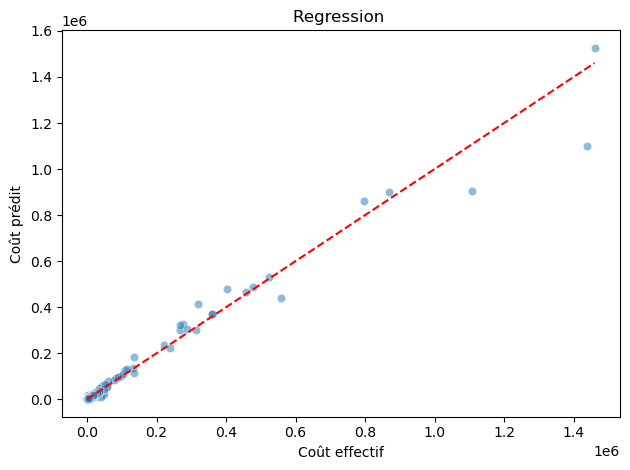

In [ ]:
# Compute residuals.

residuals = y_test - y_pred









# Plot: Regression Fit (Actual vs Predicted).

sb.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
plt.title("Regression ")
plt.xlabel("Coût effectif")
plt.ylabel("Coût prédit")


# Show plots.
plt.tight_layout()
plt.show()